In [1]:
import pandas as pd 
import pickle
import string
from pymongo import MongoClient 
from datetime import datetime,timedelta
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
import logging
import pymagnitude
import sys
import numpy as np
import pandas_profiling
import datetime
import itertools
import logging
logger = logging.getLogger(__name__)

sys.path.insert(0, "//home//nlpsomnath//NegNews//zackc//Misc Notebooks//NN_VM//lib//python3.7//site-packages//negative_news//negative_news//util//")
from fines import get_data_from_article_title, transform_article_title, load_entity_dict, generate_report_string, max_marketshare
from desm import desm_pandas_wrapper

import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

logger = logging.getLogger(__name__)
sent_tokenizer = nltk.tokenize.sent_tokenize
word_tokenizer = nltk.tokenize.word_tokenize

stopwords = stopwords.words('english')
newStopWords = ['.','?','%','&','Google','Wells Fargo','Donald Trump','Charles Schwab','Morgan Stanley','Credit Suisse','Reuters','Bank of America','Guggenheim','Deutsch Bank','Goldman Sachs','Facebook','Fifth Third Bank','New York','Washington','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday','January','February','March','April','May','June','July','August','September','October','November','December']
stopwords.extend(newStopWords)

#CONSTANTS
RESOURCES_PATH="/home/nlpsomnath/.local/lib/python3.5/site-packages/negative_news/resources/"
OUTPUT_PATH = "/home/nlpsomnath/NegNews/zackc/ContainerOutput/"

#one liner to fix issue with lazyconfig load 
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""


#FUNCTION TO EXTRACT MIC FOR MEASURING CORROLATION OF NON LINEAR RELATIONSHIPS ACROSS CONTINOUS SERIES
def get_MIC(x,y):
    import numpy as np
    from minepy import MINE
    mine = MINE(alpha=0.6, c=15, est="mic_approx")
    mine.compute_score(x, y)
    MIC = mine.mic()
    return MIC 

def normalize_pandas_series(series, _max=None, _min=None):
    if _max is None:
        if series.max() == 0:
            _max = 1
        else:
            _max = series.max()
    if _min is None:
        _min = series.min()
    return (series - _min) / (_max - _min)
             
def df_rowtypes(df,cols):
    df_copy = df.copy()
    df_copy.index = df.index
    df_copy.columns = df.columns

    #loop over indexes for each column and determine the type of data in each row of each column 
    #assignment to new dataframe based on idx location
    for col in cols:
        for i in df.index:
            val = type(df.loc[i, col]).__name__ 
            if val =='list':
                df_copy.loc[i, col] = len(df.loc[i, col])
            elif val =='dict':
                df_copy.loc[i, col] = len(df.loc[i, col].keys())
            else:
                df_copy.loc[i, col] = val
    return df_copy

def Desm_dict_to_df(row):
    
    #convert a dictonary of key : [(tup1_a,tup1_b),(tup2_a,tup2_b),.....] value pairs 
    #into a dataframe , where each column is representative of the column name in the resultign dataframe
    try:
        jobname = row['jobname']
        url = row['url']
        entity=row['entity']
        desm_dict = row['desm_score_dict']
        sents = row['sentence_tokenized_english']
    except KeyError as error:
        logger.error(print("Key {} Not found in Dictnary".format(error)))
        raise Exception("Key {} Not Found".format(error))
        
    #convert dictonary of tuples into a dataframe
    df = pd.DataFrame.from_dict(desm_dict,orient='columns')
    df_copy = df.copy()
    df_copy.index = df.index
    df_copy.columns = df.columns
    
    #reassign values back to a copy of original datafarme and return copied dataframe
    #removing the sentence index from each tuple, this information is retained in the index of the resulting dataframe
    #storing sent_index to ensure we retain correct order of sentences within each article
    sentindexs=[]
    for col in df.columns:
        for i in df.index:
            df_copy.loc[i, col] = df.loc[i, col][1]
            sentindexs.append(df.loc[i, col][0])
    df_copy['jobname']=jobname
    df_copy['url'] = url
    df_copy['entity']=entity
    df_copy['sentence']= pd.Series(sents)
    df_copy['sent_index'] = pd.Series(sentindexs)
    return df_copy

def numcols(df=None,numeric=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    cols = []
    for idx in df.index:
        for col in df.columns:
             if idx == df.index[0]:
                dype = type(df.loc[idx,col]).__name__
                
                if (numeric == True) & (dype in numerics):
                    #print('yes')
                    cols.append(col)
                if (numeric == False) & (dype not in numerics):
                    cols.append(col)
    return cols

def binVars_Longdf(df=None,var=None,var2replace=None,level=None,Thresholds=[-.05,.05,-.06]):
    df_copy = df.copy()
    df_copy.index = df.index
    df_copy.columns = df.columns

    for idx in df_copy.index:
        if df_copy.loc[idx,var]==level:
            sentval = df_copy.loc[idx,var2replace]

            if sentval < Thresholds[0]:
                df_copy.loc[idx,var2replace] = 0
            if sentval > Thresholds[1]:
                df_copy.loc[idx,var2replace] = 2
            if (sentval > Thresholds[2]) &(sentval <= Thresholds[1]):
                df_copy.loc[idx,var2replace] = 1
    return df_copy

#reset index of dataframe with categorical columns 
def Reset_index(df):
    '''Returns DataFrame with index as columns'''
    index_df = df.index.to_frame(index=False)
    df = df.reset_index(drop=True)
    #  In merge is important the order in which you pass the dataframes
    # if the index contains a Categorical. 
    # pd.merge(df, index_df, left_index=True, right_index=True) does not work
    return pd.merge(index_df, df, left_index=True, right_index=True)

import random
 
def colorsN(n):
    ret = []
    r = int(random.random() * 256)
    g = int(random.random() * 256)
    b = int(random.random() * 256)
    step = 256 / n
    for i in range(n):
        r += step
        g += step
        b += step
        r = int(r) % 256
        g = int(g) % 256
        b = int(b) % 256
        ret.append((r,g,b)) 
    return ret


#### Load Data

In [2]:
##### Load Pickle of saved results
data=pickle.load( open( "{}".format(OUTPUT_PATH)+"DF_With_DESM_Scores.pickle", "rb" ) )
data = pd.DataFrame(data)

#### Create datetime column and remove null dates
data['date'] = pd.to_datetime(data['date'],errors='coerce')
data = data[~data['date'].isnull()]
data['year'] = pd.DatetimeIndex(data['date'],ambiguous='NAT').year.astype(int)
data['date'].value_counts(dropna=False)

2019-03-14 00:00:00.000    157
2018-04-20 00:00:00.000    106
2019-03-13 00:00:00.000     81
2018-09-28 00:00:00.000     72
2019-03-07 00:00:00.000     71
2018-05-11 00:00:00.000     67
2018-05-10 00:00:00.000     67
2018-03-15 00:00:00.000     54
2018-09-20 00:00:00.000     54
2019-02-20 00:00:00.000     51
2019-03-18 00:00:00.000     50
2019-03-12 00:00:00.000     49
2018-03-14 00:00:00.000     48
2018-02-05 00:00:00.000     45
2018-10-01 00:00:00.000     43
2019-03-08 00:00:00.000     41
2018-03-29 00:00:00.000     41
2018-08-09 00:00:00.000     40
2019-02-22 00:00:00.000     40
2018-01-29 00:00:00.000     39
2018-05-17 00:00:00.000     39
2018-04-19 00:00:00.000     39
2018-05-04 00:00:00.000     38
2018-06-20 00:00:00.000     38
2019-01-29 00:00:00.000     38
2018-07-19 00:00:00.000     37
2017-12-07 00:00:00.000     37
2018-06-25 00:00:00.000     37
2018-12-18 00:00:00.000     37
2018-03-23 00:00:00.000     37
2019-02-21 00:00:00.000     37
2019-03-06 00:00:00.000     37
2018-02-

#### Subset total results for 2017 and 2018 only 

In [4]:
years = [2017,2018,2019]
ENTITIES2SAMPLE = ['Jes Staley','Wells Fargo','Deutsche Bank','Barclays','UBS','Lek Securities','LPL','Bank of America','MUFG','Rabobank','Standard CHartered','Brighthouse','Wedbush','J.P. Morgan Securities','Chase Bank','TIAA']
RiskiestNumDocs2Sample = 100

data = data[(data['year'].isin(years))&(data['entity'].isin(ENTITIES2SAMPLE))]
data =  data.sort_values(by=['entity','max_desm_score'], ascending=False)
data = data.groupby('entity').head(RiskiestNumDocs2Sample)
data.head()

_id                                            content                date       entity                        jobname                                           origtext        scraper                 source                                            summary                                              title                                                url                                 sentence_tokenized                  sentence_tokenized_word_tokenized                              name_fuzzy_score_list  entity_count  keep                             window_filter_idx_list                         sentence_tokenized_english  max_desm_score                                     desm_sentences    desm_term                                    desm_score_dict                                         term_tupes                                 sentence_sentiment  doc_sentiment                               tagged_top_sentences  \
325   e655bdd7afb3f48b0691105718bab8d8e00ff8ca  Wells Fargo will pay $1 billion in fines to tw... 2018-04-20 12:27:00  Wells Fargo  Wells Fargo_03-13-19-17-06-13  \n Wells Fargo will pay $1 billion in fines to...  BingSearchAPI  Charlotteobserver.com  Wells Fargo was fined $1.5 billion from U.S. b...      U.S. regulators fine Wells Fargo $1.5 billion  https://www.charlotteobserver.com/news/busines...  [Wells Fargo will pay $1 billion in fines to t...  [[Wells, Fargo, pay, 1, billion, fines, two, U...  [100, 36, 27, 36, 45, 100, 36, 100, 45, 100, 1...            34     2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  [Wells Fargo will pay $1 billion in fines to t...        0.403842  [Wells Fargo will pay $1 billion in fines to t...  restitution  {'sanction': [(0, 0.26232829689979553), (1, 0....  [(restitution, 0.4038415849208832), (escalatio...  [-0.3818, -0.6486, 0.0, -0.296, 0.6808, 0.8378...      -0.556600  [(Wells, Fargo, will, pay, $, 1, billion, in, ...   
50    bef3b18ec59ecf883bb09de1211724862702b63a  Wells Fargo &amp; Co. must pay $97 million to ... 2018-05-09 00:00:00  Wells Fargo  Wells Fargo_03-13-19-17-06-13  Wells Fargo &amp; Co. must pay $97 million to ...        NewsAPI              Bloomberg  Wells Fargo & Co. must pay $97 million to home...  Wells Fargo Owes California Bankers $97 Millio...  https://www.bloomberg.com/news/articles/2018-0...  [Wells Fargo &amp; Co. must pay $97 million to...  [[Wells, Fargo, amp, Co., must, pay, 97, milli...                [100, 45, 55, 100, 36, 36, 100, 45]             8     2                           [0, 1, 2, 3, 4, 5, 6, 7]  [Wells Fargo &amp; Co. must pay $97 million to...        0.378803  [Wells Fargo &amp; Co. must pay $97 million to...  restitution  {'sanction': [(0, 0.1973012387752533), (1, 0.2...  [(restitution, 0.3788028558095296), (escalatio...  [0.4019, 0.2263, -0.5106, -0.5106, -0.7506, -0...      -0.590600  [(Wells, Fargo, &, amp, ;, Co., must, pay, $, ...   
149   73e4ac487ada0148cf0ec104c1ccaec474264be0  It's the largest penalty the Justice Departmen... 2018-08-14 00:00:00  Wells Fargo  Wells Fargo_03-13-19-17-06-13  It's the largest penalty the Justice Departmen...        NewsAPI                    CNN  Royal Bank of Scotland will pay $4.9 billion t...  Royal Bank of Scotland will pay record fine fo...  https://money.cnn.com/2018/08/14/news/companie...  [It's the largest penalty the Justice Departme...  [['s, largest, penalty, Justice, Department, i...  [45, 45, 36, 45, 36, 36, 45, 36, 55, 27, 45, 3...            15     2  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...  [It's the largest penalty the Justice Departme...        0.367973  [It's the largest penalty the Justice Departme...     sanction  {'sanction': [(0, 0.4615064561367035), (1, 0.3...  [(restitution, 0.3205270767211914), (escalatio...  [0.0258, 0.6369, 0.1798, 0.0, 0.7906, 0.4215, ...      -0.402867  [(It, 's, the, largest, penalty, the, Justice,...   
2492  75b038034bf29b2443faed6de26d93283921e771  The bank neither admitted nor denied any wrong... 2018-04-21 04:03:44  

## Expanded Document Level Dataset
*Contains document level metrics for each term in analysis  

In [6]:
#convert document term tupe scores into columns 
words = list(set([item for sublist in [[x[0] for x in data.term_tupes[i]] for i in data.index] for item in sublist]))
data[words] = pd.DataFrame(data['term_tupes'].tolist(),index = data.index)


#rename column tuple term columns based on first elementin the row of each column 
old_names = words
new_names = []
for i in data.index:
    if i == data.index[0]:
        for col in words:
            new_names.append(data[col][i][0])

#replace original term column name with correct one 
data.rename(columns=dict(zip(old_names, new_names)), inplace=True)

#reassign each row of each column associated with term tup to the second element of each tuple (the actual max corr for the tup in the doc)
for col in new_names: 
    data[col] = data[col].apply(lambda x: x[1])
    
#drop id 
#data.drop(columns = ['_id'], inplace=True)

#subset columns to columns associated with document level information 
DocData = data[['content','date','entity','jobname','scraper','source','summary','title','url','entity_count','keep',
                'max_desm_score','desm_term','doc_sentiment','year','sanction','revoke','penalty','escalation',
                'deficiencies','restitution','suspension','fined','violation','collude']]

## Start: Sentence Level Similairty and Sentiment DataFrame Construction 

#### Specify Columns for Sentence level dataset and  Check Column Data Types

In [7]:
#Columns from input dataset we want to consider
cols = [ 'jobname'
        ,  'date'
        ,  'entity'
        , 'scraper'
        , 'source'
        , 'summary'
        , 'title'
        , 'url'
        , 'max_desm_score'
        , 'doc_sentiment'
        , 'entity_count'               #source = name_fuzzy_score_list + title 
        , 'name_fuzzy_score_list'      #source = sentence_tokenized + enity Name
        , 'sentence_tokenized'         #source = content (FINAL SENTENCE_TOKENIZED is a subset of original based on weather sentence flagged by winodow-filter_idx_list)
        , 'window_filter_idx_list'     #source = sentence_tokenized + name_fuzzy_score_list
        , 'sentence_tokenized_english' #source = sentence_tokenized  (Exact same unless translation used)
        , 'sentence_sentiment'         #source = sentence_tokenized_english (returns list of sentence sentiment values for each sentence in sentence_tokenized_enllish)
        , 'desm_sentences'             #source = sentence_tokenized_word_tokenized + risk_stems
        , 'desm_score_dict'            #source = sentence_tokenized_word_tokenized + risk_stems
        , 'term_tupes'                 #source = desm_score_dict (list of terms found in each sentence)
        , 'tagged_top_sentences'       #source = title + desm_sentences       
       ]

#look at the type of information in each columns
#leverage the length of the list attribute to identify which lists are derived from what (the list lengths should be equal if they are used together)
print('checking data granularity')
print(data.groupby(["entity","url"]).agg({"jobname":pd.Series.nunique, "date": pd.Series.nunique,"scraper": pd.Series.nunique}))
print('NOTE: Data unique at the (entity + url) level')
print('checking column value dtypes')
df_rowtypes( data[cols].head(3),cols)




checking data granularity
                                                                    jobname  scraper  date
entity          url                                                                       
Bank of America http://www.businessinsider.com/eu-copyright-ref...        1        1     1
                http://www.occ.gov/news-issuances/news-releases...        1        1     1
                http://www.occ.gov/news-issuances/news-releases...        1        1     1
                https://apnews.com/f6822f1313e2499883348a5615d2...        1        1     1
                https://ftw.usatoday.com/2018/10/jimmie-johnson...        1        1     1
                https://www.bankrate.com/financing/banking/judg...        1        1     1
                https://www.bizjournals.com/newyork/news/2018/0...        1        1     1
                https://www.bloomberg.com/news/articles/2017-12...        1        1     1
                https://www.bloomberg.com/news/articles/2018-02.

jobname       date entity scraper source summary title  url max_desm_score doc_sentiment entity_count name_fuzzy_score_list sentence_tokenized window_filter_idx_list sentence_tokenized_english sentence_sentiment desm_sentences desm_score_dict term_tupes tagged_top_sentences
325     str  Timestamp    str     str    str     str   str  str        float64       float64        int64                    34                 34                     34                         34                 34              3              11         11                    3
50      str  Timestamp    str     str    str     str   str  str        float64       float64        int64                     8                  8                      8                          8                  8              3              11         11                    3
149     str  Timestamp    str     str    str     str   str  str        float64       float64        int64                    15                 15                     15                         15                 15              3              11         11                    3

#### Subset columns to retain when extracting sentence level desm scores from each URL<br> Note: sentence level desm sentences are stored in nested lists and dicts) 

In [9]:
#Subsetting data to only include sentence level information (that is nested in lists and dicts) 
#sentence level that we are going to extract 
#NOTE: sentence_sentiment based sentence_sentence_tokenized_english
#NOTE: Becuase DESM_SCORE_DICT CONTAINS SENTENCE LEVEL SIMILARITY INFO, WE DO NOT NEED TO BREAK OUT INTO 2 DATASETS
Similarity_Cols =  [ 'jobname',  'date',  'entity', 'scraper', 'source', 'title','url'
                    , 'max_desm_score', 'doc_sentiment', 'entity_count'     
                    , 'desm_score_dict','sentence_tokenized_english' , 'sentence_sentiment']   

DF_Similarity = data[Similarity_Cols]

#### Extract the desm sentences from each URL (desm_score dict contains all sentences for the row~URL)
- Convert dictonary of key : [(tup1_a,tup1_b),(tup2_a,tup2_b),.....] value pairs  into a dataframe each term in the dictonary is representative of the column name in the resulting dataframe
- **Note:** all output  from function saved  to object
##### Output Structure
- **Index:** Sentence Level 
* **Output Syntax:** helpme[helpme.index[0]]
* **Output Format:** 1 column for each term desm scores were calculated for, retaining identifying metadata columns to join back to final sentence level dataframe 

In [11]:
helpme=DF_Similarity.head(100).apply(lambda x: Desm_dict_to_df(x),axis=1)

##### Create a single dataframe from each indexed row 
* Input: Each indexed row from output of desm_dict_to_df and append it to a new dataframe 
* Output: Sentence level dataframe, with desm scores for each term for each sentence in each URL 

In [13]:
#create single dataframe from desm_score_dict dfs created above
for idx in helpme.index:
    #print('NewData:{}'.format(idx),helpme[idx].shape)
    
    #get copy of dataset 
    newdf = helpme[idx].copy()
   
    #if its the first index create a new df 
    if idx == helpme.index[0]:
        df=newdf
    #otherwise append to the existing df 
    else:
        df = df.append(newdf, ignore_index=False)

#create 2 additioanl columns to use when joining similarity and sentiment informaiton together
df['sent_len']=df['sentence'].apply(lambda x: len(x))
df['sent_first20']=df['sentence'].apply(lambda x: x[:20])

print(df.shape)
df.head(13)

(2050, 18)


collude deficiencies escalation      fined infringement   penalty restitution    revoke  sanction suspension violation                        jobname                                                url       entity                                           sentence  sent_index  sent_len          sent_first20
0    0.151398     0.148687   0.218709   0.250935    0.0640485  0.193973    0.295086  0.187189  0.262328   0.201511  0.173703  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  Wells Fargo will pay $1 billion in fines to tw...           0       167  Wells Fargo will pay
1      0.2097     0.117589   0.184178   0.225644     0.140402  0.161106    0.296538  0.243079  0.184311  0.0752798  0.219552  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  The Consumer Financial Protection Bureau and t...           1       198  The Consumer Financi
2    0.120165      0.11103   0.100273    0.32547     0.112311  0.130409    0.619901  0.243531  0.213245   0.178289   0.18541  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  Both ordered the bank to provide restitution t...           2        58  Both ordered the ban
3   0.0420226      0.15074   0.110335  0.0608412     0.105104  0.108173    0.176456  0.138879  0.179621   0.142603   0.13454  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo                          The OCC also said the No.           3        25  The OCC also said th
4    0.222129     0.179499    0.13957   0.131854    0.0698349  0.136753    0.213641  0.255055  0.261857   0.109338  0.141524  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  3 U.S. bank by assets must get its approval be...           4       108  3 U.S. bank by asset
5    0.163586     0.153829   0.137786   0.181033     0.124245  0.176762    0.165518  0.232267   0.20358   0.136835  0.202662  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  Sign Up and Save Get six months of free digita...           5       227  Sign Up and Save Get
6    0.123585     0.138397   0.193348   0.205173      0.17232  0.192682    0.277882  0.165472  0.265073   0.168867  0.222081  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  The agreement is another black mark for an ins...           6       142  The agreement is ano
7    0.155286      0.20108   0.187744   0.179269     0.133108  0.279964    0.268179  0.254109  0.247373   0.220639  0.210936  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  Both regulators on Friday said Wells Fargo wro...           7       213  Both regulators on F
8    0.265725     0.274957   0.188852   0.227491     0.204018  0.253687    0.266575  0.176741  0.239434    0.16132  0.305953  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  The agencies also faulted the bank for imprope...           8       210  The agencies also fa
9   0.0747767     0.173662   0.236165   0.182118     0.154672  0.122922    0.226136  0.148442  0.163546   0.115018  0.122336  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  The settlement adds to legal costs Wells Fargo...           9       168  The settlement adds 
10  0.0593521     0.318855   0.173571   0.131165      0.11362  0.121911    0.198122  0.158604  0.184747   0.163257   0.21033  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  Read Next March 14, 2018 4:25 PM In a statemen...          10       267  Read Next March 14, 
11   0.242701     0.228999   0.173423    0.10969     0.127569  0.097192    0.198419   0.17854  0.227093  0.0863912  0.148557  Wells Fargo_03-13-19-17-06-13  https://www.charlotteobserver.com/news/busines...  Wells Fargo  "Whil

#### Extract Sentences and Sentence level Sentiment information from Sentence_tokenized_english and sentence_sentiment respectivly 

* Note: Sentence level sentiment informatoin will be joined back to sentence level desm scores. All columns from original input dataframe(data) that we want to include in the sentence level dataframe must be specific here

In [53]:
#convert Sentiment level data from document level to sentence level 
#Sentiment sentence level information is stored in a list (unlike desm_score_dict which is a dictonary)
rows = []

#doclevel and sentence sentiment level dict 
sim_subs=  [ 'jobname',  'date',  'entity', 'scraper', 'source', 'title','url'
       , 'max_desm_score', 'doc_sentiment', 'entity_count'
       ,'sentence_tokenized_english' , 'sentence_sentiment']   

#create unique row for  every item in the zipped list and 
#duplicate document level information for each sentence to enable
#easy mapping of sentences back to higher level entity/document data  
_ = DF_Similarity[sim_subs].apply(lambda row: [rows.append([row['jobname']
#_ = DF_Similarity[DF_Similarity['entity'].isin(ENTITIES2SAMPLE)][sim_subs].apply(lambda row: [rows.append([row['jobname']
#_ = DF_Similarity[sim_subs].head(NUMDOCS2SAMPLE).apply(lambda row: [rows.append([row['jobname']
                                              ,row['date']
                                              ,row['entity']
                                              ,row['scraper']
                                              ,row['source']
                                              ,row['title']
                                              ,row['url']
                                              ,row['max_desm_score']
                                              ,row['doc_sentiment']
                                              ,row['entity_count']
                                                 
                                              ,sentence,sentiment])
                         for sentiment,sentence in zip(row.sentence_sentiment,row.sentence_tokenized_english)],axis=1)

Sentiment_DF = pd.DataFrame(rows,columns = DF_Similarity[sim_subs].columns)

#determining sent length, which is used as one of the multi-part key for joining sentiment and similarity information at the sentence level 
Sentiment_DF['sent_len']=Sentiment_DF['sentence_tokenized_english'].apply(lambda x: len(x))
Sentiment_DF['sent_first20']=Sentiment_DF['sentence_tokenized_english'].apply(lambda x: x[:20])

print(Sentiment_DF.shape)
Sentiment_DF.head(2)

(108920, 14)


jobname                date       entity        scraper                 source                                              title                                                url  max_desm_score  doc_sentiment  entity_count                         sentence_tokenized_english  sentence_sentiment  sent_len          sent_first20
0   Jes Staley_03-14-19-12-05-44 2018-05-11 11:00:11   Jes Staley  BingSearchAPI  Compliancemonitor.com  Jes Staley fine rates 2 out of 5 on seriousnes...  https://www.compliancemonitor.com/uk-regulatio...        0.414109        -0.5859             1  Regulators have fined Barclays CEO Jes Staley ...             -0.5859       204  Regulators have fine
1  Wells Fargo_03-13-19-17-06-13 2018-04-20 12:27:00  Wells Fargo  BingSearchAPI  Charlotteobserver.com      U.S. regulators fine Wells Fargo $1.5 billion  https://www.charlotteobserver.com/news/busines...        0.403842        -0.5566            34  Wells Fargo will pay $1 billion in fines to tw...             -0.3818       167  Wells Fargo will pay

#### FINAL SENTENCE LEVEL DF
* JOIN SENTENCE LEVEL SIMILAIRTY AND SENTIMENT INFORMATION INTO CONSOLIDATED DATASET <BR>FINAL DATASET WITH ALL SENTIMENT AND SIMILARITY VALUES AT THE SENTENCE LEVEL 
* **KEY TO JOIN SENTIMENT & DESM:** jobname + url + entity + sent_len

In [56]:
result = pd.merge(df, Sentiment_DF,how='left', on=[ 'entity','jobname', 'url','sent_len','sent_first20'], sort=False)
result = result.drop(['sent_len','sent_first20','sentence_tokenized_english'],axis=1)

#drop column incorrectly named
drop = ['infridgement']
result = result.drop(drop,axis=1)

#drop duplicate rows(not sure what the root cuase is of them)
result.drop_duplicates(keep='first',inplace=True)
print(result.shape,result.columns)

print(result.shape,Sentiment_DF.shape,df.shape)

(111671, 23) Index(['collude', 'deficiencies', 'escalation', 'fined', 'penalty', 'restitution', 'revoke', 'sanction', 'suspension', 'violation', 'jobname', 'url', 'entity', 'sentence', 'sent_index', 'date', 'scraper', 'source', 'title', 'max_desm_score', 'doc_sentiment', 'entity_count', 'sentence_sentiment'], dtype='object')
(111671, 23) (108920, 14) (108669, 18)


#### Basic Statistical Profile of final dataset

In [78]:
#pandas_profiling.ProfileReport(result)
#result.sentence_sentiment.value_counts()

#### Convert the wide dataframe into long data frame for visualizing

In [79]:
#Numcols to include in conversion from long to wide data for modeling/visualizing 
NumCols = numcols(df=result,numeric=True)

#Non Numeric columns to keep in there existing level (ID Columns to melt on)
ID_COL = ['entity','date']

#all cols 
Cols = NumCols+ID_COL

#melt wide dataframe into long dataframe 
melt_df = pd.melt(result[NumCols+ID_COL], id_vars = ID_COL,var_name='features',value_name='value')
melt_df['value']=melt_df.value.astype(float)
melt_df['year'] = pd.DatetimeIndex(melt_df['date']).year
melt_df['month'] = pd.DatetimeIndex(melt_df['date']).month
melt_df['day'] = pd.DatetimeIndex(melt_df['date']).day

#### DENDOGRAM GENERATION 
* Current Year Avg Similarity with each risk term (and sentiment cluster)
* YOY change in similarity with respect to each risk term 

In [80]:
####  *Identify all entities present in both 2017 and 2018(2 full years)
#### *Subset long dataframe on only those entities in both years
#identfy the common entities across both years
entities = list(set(melt_df[melt_df['year']==2018]['entity'].unique()).intersection(melt_df[melt_df['year']==2017]['entity'].unique()))
print(entities)
#subset melt_df to only include entities from both years 
melt_df = melt_df[melt_df['entity'].isin(entities)]

##### Define constants to use when creating YOY Comparisons
#years 2 compare YoY
years = [2017,2018]

#vars to group by 
var_list=['entity','features']

#column to perform aggregation on 
metric=['value']

#unnormalized metrics to remove (skew dendogram)
unnormilized_feats2rm = ['entity_count', 'sent_index','date','max_desm_score','doc_sentiment']

#### Create 2 sets of DFs(one for each year being compared)<br> 
#### DF OUTPUT: Annual Avg value for each feature for each entity 
#create list of DFS for each year grouped by the variables in var_list 
dfs =[melt_df[(melt_df['year']==YEAR) & (~melt_df['features'].isin(unnormilized_feats2rm)
                                           )].groupby(var_list,as_index=False)[metric].mean() for YEAR in years]

#ientify columns that are non numeric that need to be converted from object to categorical 
catcols = [numcols(df=x,numeric=False) for x in dfs] 

#convert all non numeric columns to categoric 
for i in range(0,len(dfs)):
    dfs[i][catcols[i]] = dfs[i][catcols[i]].apply(pd.Categorical)
    
#### Create binned variable to cluster on in dendogram
####* Note: Binning based on variable format in long dataframe
#constants
var = 'features'
var2replace = 'value'
level = 'sentence_sentiment'
Thresholds = [-.05,.05,-.06]       

#lsit comprehension across both dfs to replace sent values with bin values
dfs = [binVars_Longdf(df=x,var=var,var2replace=var2replace,level=level,Thresholds=Thresholds) for x in dfs]

#### Pivot the resulting dataframes back to wide format 
#convert the pivoted dataframes to matrices to enable matrix calculations 
DFS_PIV = [x.pivot( "entity" ,"features" , "value") for x in dfs]
DFS_PIV[0]['sentence_sentiment'] =DFS_PIV[0]['sentence_sentiment'].astype(int)
DFS_PIV[1]['sentence_sentiment'] =DFS_PIV[1]['sentence_sentiment'].astype(int)

#perform matrix operations on two equal size matrices to identify the YOY change in avg similarity across each risk term
current = DFS_PIV[1]
lastyear = DFS_PIV[0]
YOY_diff = (current- lastyear)/lastyear

###################
# cluster map plot#
###################
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

lut = dict(zip(current['sentence_sentiment'].unique(), "rbg"))
row_colors = current['sentence_sentiment'].map(lut)
sns.clustermap(current.drop(columns =['sentence_sentiment']),
               metric="correlation",
               col_cluster=True,
               row_cluster=True,
               method="single", 
               cmap="Blues", 
               row_colors=row_colors,
              )

import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

#########################
###YOY CHANGE CLUSTERMAP#
#########################
#create heatmaps to illistrate change in relevance of different risks YOY
gf = YOY_diff[ YOY_diff.index!= 'sentence_sentiment' ]
sns.clustermap(gf,cmap='coolwarm', annot=True,annot_kws={"size": 8},col_cluster=True,row_cluster=False,linewidth=2,figsize=(10,8), standard_scale=0) # standard_scale=1 *columns

['LPL', 'Barclays', 'Jes Staley', 'Chase Bank', 'TIAA', 'Wedbush', 'Wells Fargo', 'Bank of America', 'MUFG', 'Brighthouse', 'Deutsche Bank', 'Lek Securities', 'Rabobank', 'J.P. Morgan Securities', 'UBS']


### Document Level Analysis 

##### data profile overview

In [25]:
pandas_profiling.ProfileReport(DocData)
DocData.describe()
DocData.dtypes

#subset columns to conduct preliminary (before differencing through time) corrolation analysis
DocCorVars = ['entity_count','max_desm_score','doc_sentiment','sanction','revoke','penalty','escalation',
                'deficiencies','restitution','suspension','fined','violation','collude']

KeyboardInterrupt: 

###### outliers 
* PyOD:library to detect outliers in your data. Provides access to more than 20 different algorithms to detect outliers

###### Methods
* **Angle-Based Outlier Detection (ABOD)**:considers the relationship between each point and its neighbor(s).it does **NOT** consider the relationships among these neighbors. The variance of its weighted cosine scores to all neighbors could be viewed as the outlying score
    * Fast ABOD: Uses k-nearest neighbors to approximate
    * Original ABOD: Considers all training points with high-time complexity
* **k-Nearest Neighbors Detector**:For any data point, the distance to its kth nearest neighbor could be viewed as the outlying score
* **Isolation Forest**:data paritioning is done using a set of trees. Isolation forest provides an anomly score looking at how isolated the point is in the structure 
* **Local Correlation Integral (LOCI)**: **BEST APPROACH** LOCI is very effective for detecting outliers and groups of outliers. It provides a LOCI plot for each point which summarizes a lot of the information about the data in the area around the point, determining clusters, micro-clusters, their diameters, and their inter-cluster distances

In [ ]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager
from pyod.models.abod import ABOD
from pyod.models.knn import KNN
from pyod.utils.data import generate_data, get_outliers_inliers

outlier_fraction = .05

In [ ]:
X_train = DocData[['entity_count','doc_sentiment']]


F1 = X_train['entity_count']
F2 = X_train['doc_sentiment']
# create a meshgrid 
xx , yy = np.meshgrid(np.linspace(-1, 1, 1406), np.linspace(-1, 1, 1406))

# scatter plot 
plt.scatter(F1,F2)
plt.xlabel('F1')
plt.ylabel('F2') 

from pyod.models.knn import KNN   # kNN detector

X_train = DocData[DocCorVars]


# train kNN detector
clf_name = 'KNN'
clf = KNN()
clf.fit(X_train)

# get the prediction label and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_train)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_train)  # outlier scores

In [26]:
def sentbin(row):
    if row['doc_sentiment'] > .05:
        return 'Positive'
    elif (row['doc_sentiment'] > -.06)&(row['doc_sentiment'] <.06):
        return 'Nuetral' 
    else:
        return 'Negative'


#Binn sentiment scores in there natural range 
DocData['Sentiment_Bin'] = DocData.apply(sentbin, axis=1)

#normalize data after binnning to standard range 0 - 1
DocData['entity_count'] = normalize_pandas_series(DocData['entity_count'])
DocData['doc_sentiment'] = normalize_pandas_series(DocData['doc_sentiment'])
DocData['max_desm_score'] = normalize_pandas_series(DocData['max_desm_score'])

#Create month year time column 
DocData['month_year'] = pd.to_datetime(DocData['date'],errors='coerce').dt.to_period('M').values.astype('datetime64[M]')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.p

/usr/local/lib/python3.5/dist-packages/seaborn/axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


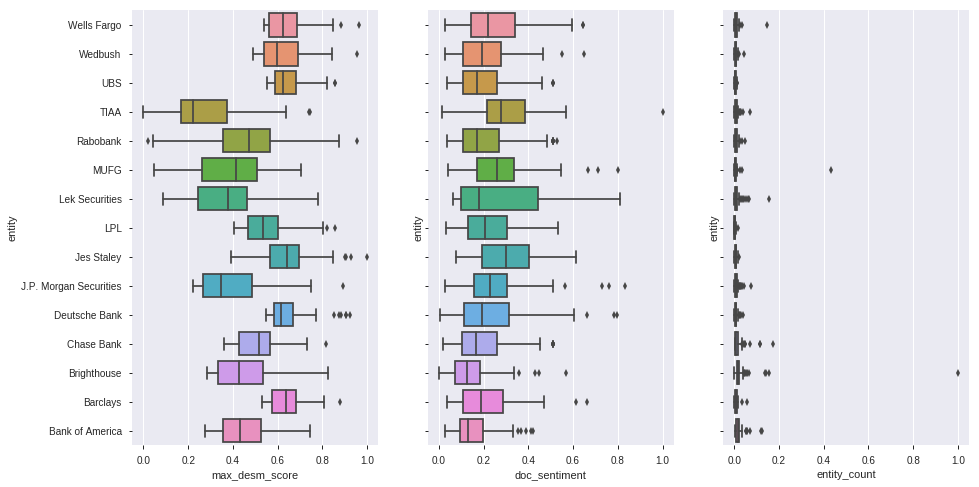

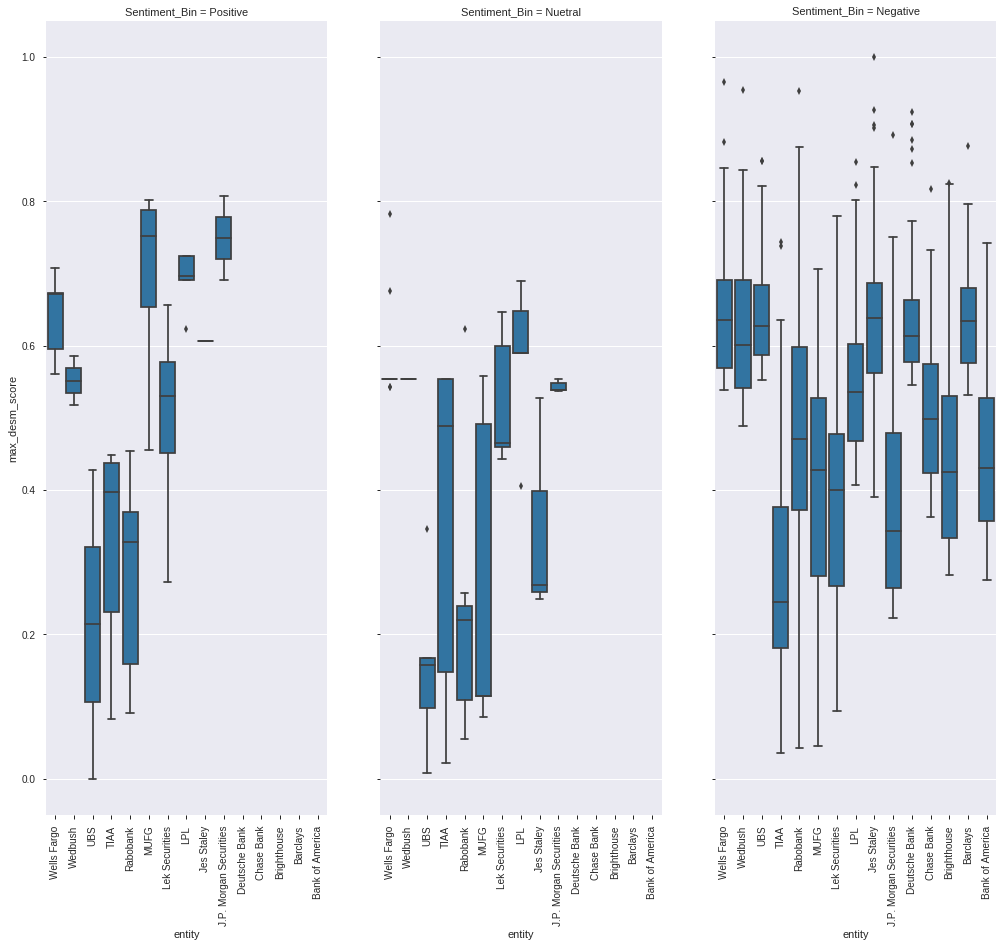

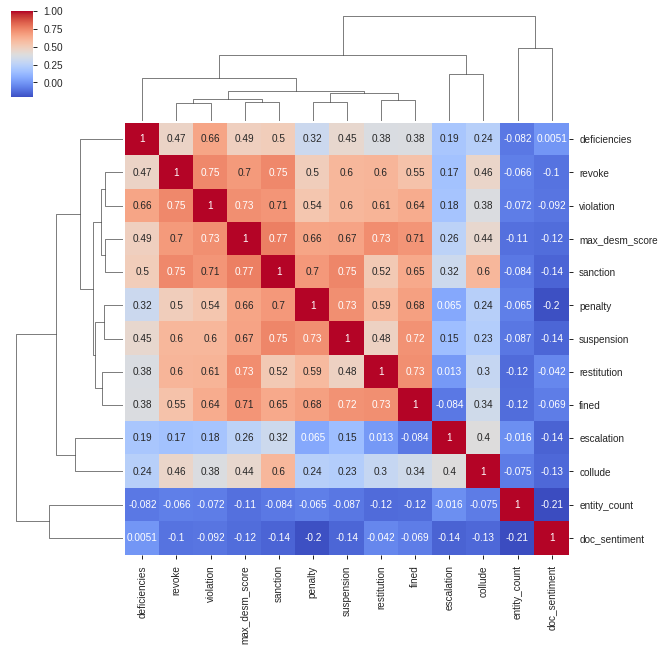

In [27]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
# call regplot on each axes

#plot high level metrics 
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, sharey=True, sharex=False,squeeze=True,figsize=(15,8))
sns.boxplot(x='max_desm_score', y='entity', data=DocData,ax=ax1)
sns.boxplot(x='doc_sentiment', y='entity', data=DocData,ax=ax2)
sns.boxplot(x='entity_count', y='entity', data=DocData,ax=ax3)

#plot by year
x = sns.FacetGrid(DocData, col='Sentiment_Bin', col_order=['Positive', 'Nuetral','Negative'], size=12, aspect=0.4)
x = x.map(sns.boxplot, 'entity', 'max_desm_score')
for ax in x.axes.ravel():
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    
#corrolation of terms 
corr = DocData[DocCorVars].corr()
ax = sns.clustermap(corr,annot = True,cmap='coolwarm')#,standard_scale=1)

### Time Series Data Analysis

#### Time Series Dataset Generation

In [28]:
#Non Numeric columns to keep in there existing level (ID Columns to melt on)
ID_COL = ['entity','month_year']
DATE_COL = ['month_year']

#num and cat cols of original DocData to include, differenced columns captured after creation 
numcols = ['entity_count','max_desm_score','doc_sentiment','sanction','revoke','penalty', 'infridgement', 'escalation', 'deficiencies', 'restitution', 'suspension', 'fined', 'violation', 'collude']
catcols =['Sentiment_Bin', 'desm_term', 'scraper', 'source']

In [29]:
#create copy of df for time series plotting
#Note: Multiple observations for the same date are consolidated in plotting through resample() using  aggregation functions(mean,median,etc...)
TimeDF = DocData.copy()
TimeDF.reset_index(inplace=True,drop=True)

#create grouped df at the year_month level (monthly)
groups = TimeDF.groupby(['entity','month_year'], as_index=False)
TimeDF_M = groups.agg(np.mean)

#TimeDF['month_year'] = pd.to_datetime(TimeDF['date'],errors='coerce').dt.to_period('M').values.astype('datetime64[M]')
TimeDF_M=TimeDF_M.sort_values(by = ['entity','month_year'], ascending=True,inplace=False)

#cols 2 create diff on 
cols2diff = ['entity_count','max_desm_score','doc_sentiment','sanction','revoke','penalty', 'infridgement'
             , 'escalation', 'deficiencies', 'restitution', 'suspension', 'fined', 'violation', 'collude']

#create diff variables 
for col in cols2diff:
    colname = 'dif_'+col
    TimeDF_M[colname] = TimeDF_M[col].diff()
    
#create lagged variables for doc sentiment and similarity 
number_lags=2
lagcols = cols2diff
for col in lagcols:
    for lag in range(1, number_lags + 1):
        TimeDF_M['lag_' + str(lag)+'_'+col] = TimeDF_M[col].shift(lag)


#all cols to include 
difcols = [col for col in TimeDF_M if col.startswith('dif')]
Cols = numcols+difcols+ID_COL
DifOnly = difcols + ID_COL

#melt wide dataframe into long dataframe 
TimeDF_ML = pd.melt(TimeDF_M[Cols], id_vars = ID_COL,var_name='features',value_name='value')
TimeDF_ML['value']=TimeDF_ML.value.astype(float)

#### Basic Time Series Visualizations

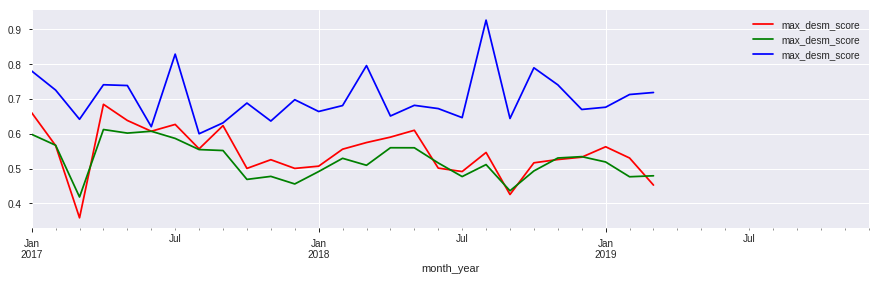

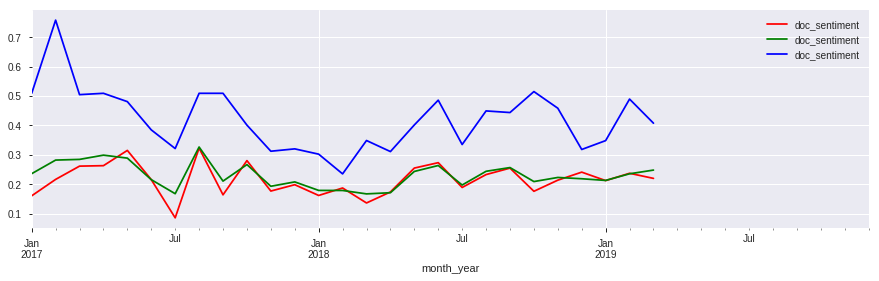

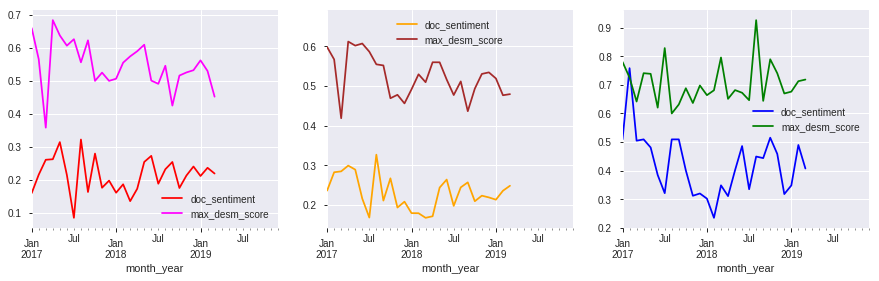

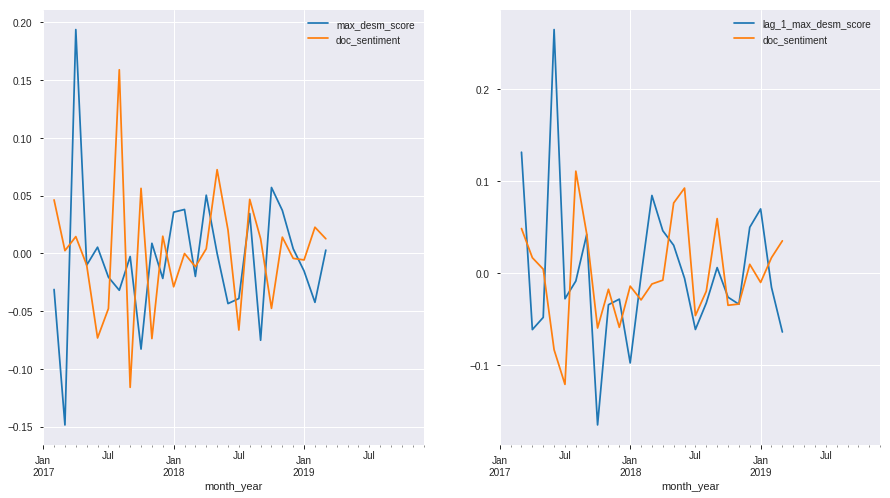

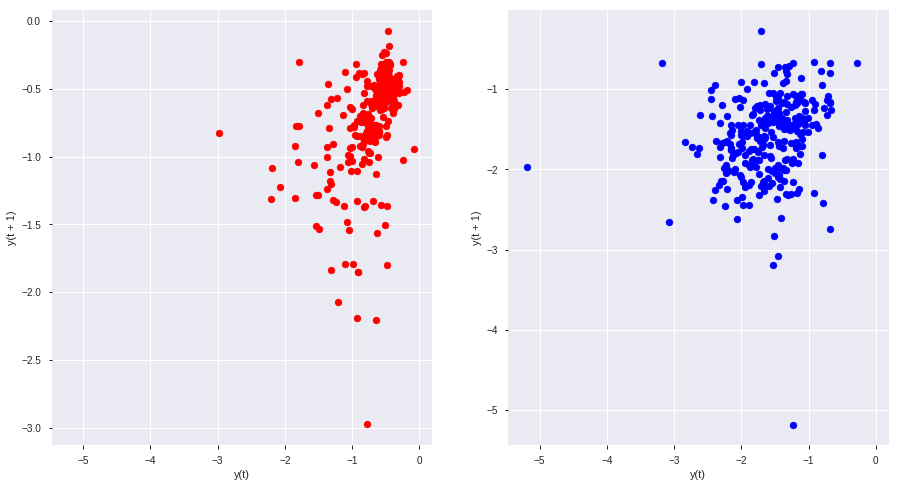

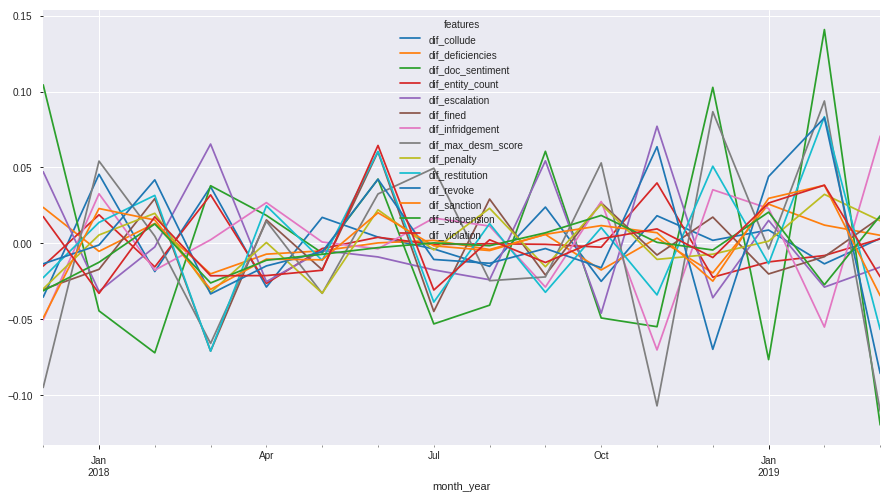

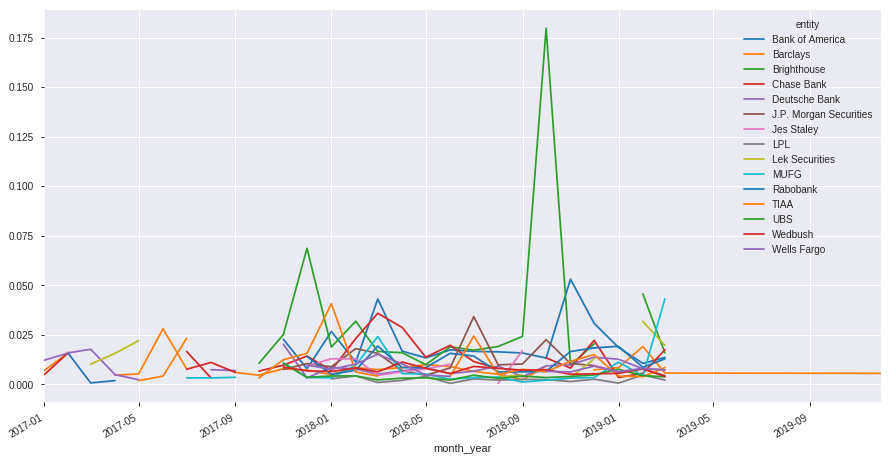

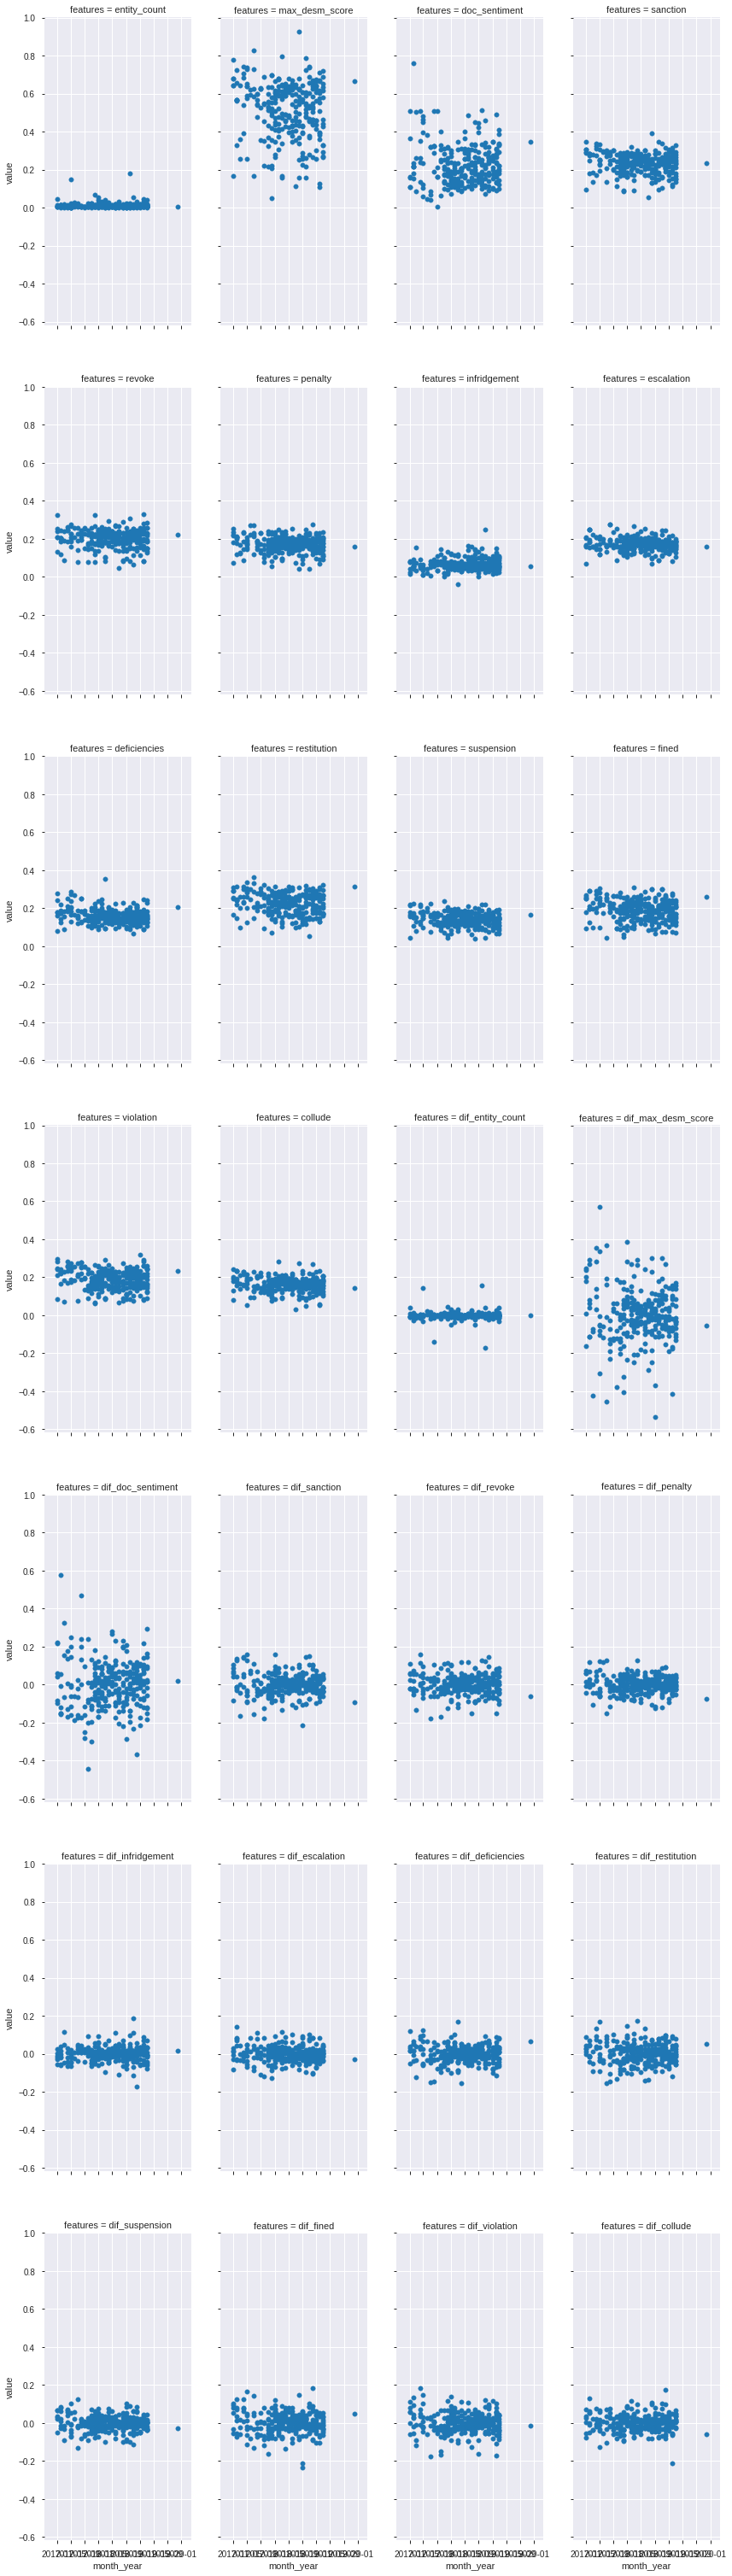

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

TimePlotDF = TimeDF_M.copy()
TimePlotDF.index = TimePlotDF['month_year']

#plot monthly values for desm scores
fig, (ax1) = plt.subplots(ncols=1, sharey=True, sharex=True,squeeze=True,figsize=(15,8))
TimePlotDF[["max_desm_score"]].resample("1m").median().plot(subplots=False,ax=ax1,color='red')
TimePlotDF[["max_desm_score"]].resample("1m").mean().plot(subplots=False, figsize=(15,4),ax=ax1,color='green')
TimePlotDF[["max_desm_score"]].resample("1m").max().plot(subplots=False, figsize=(15,4),ax=ax1,color='blue')
#plot monthly values for sentiment
fig, (ax1) = plt.subplots(ncols=1, sharey=True, sharex=True,squeeze=True,figsize=(15,8))
TimePlotDF[["doc_sentiment"]].resample("1m").median().plot(subplots=False,ax=ax1,color='red')
TimePlotDF[["doc_sentiment"]].resample("1m").mean().plot(subplots=False, figsize=(15,4),ax=ax1,color='green')
TimePlotDF[["doc_sentiment"]].resample("1m").max().plot(subplots=False, figsize=(15,4),ax=ax1,color='blue')
#plot above conbined in one plot each 
fig, (ax1,ax2,ax3) = plt.subplots(ncols=3, sharey=False, sharex=True,squeeze=True,figsize=(15,8))
TimePlotDF[["doc_sentiment","max_desm_score"]].resample("1m").median().plot(subplots=False,ax=ax1,color=['red','magenta'])
TimePlotDF[["doc_sentiment","max_desm_score"]].resample("1m").mean().plot(subplots=False, figsize=(15,4),ax=ax2,color=['orange','brown'])
TimePlotDF[["doc_sentiment","max_desm_score"]].resample("1m").max().plot(subplots=False, figsize=(15,4),ax=ax3,color=['blue','green'])
#differencing 
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=False, sharex=True,squeeze=True,figsize=(15,8))
TimePlotDF[["max_desm_score"]].resample("1m").mean().diff(1).plot(subplots=False,ax=ax1)
TimePlotDF[["doc_sentiment"]].resample("1m").mean().diff(1).plot(subplots=False,ax=ax1)
TimePlotDF[["lag_1_max_desm_score","doc_sentiment"]].resample("1m").mean().diff(2).plot(subplots=False,ax=ax2)
#are lags highlighy corrolated with current 
from pandas.plotting import lag_plot
fig, (ax1,ax2) = plt.subplots(ncols=2, sharey=False, sharex=True,squeeze=True,figsize=(15,8))
lag_plot(np.log(TimePlotDF['max_desm_score']),c='red',ax=ax1)
lag_plot(np.log(TimePlotDF['doc_sentiment']),c = 'blue',ax=ax2)

#BASIC TIME VISUALIZATIONS USING LONG DATA
for entity in TimeDF_ML.entity.unique():
    fig, (ax1) = plt.subplots(ncols=1, sharey=False, sharex=True,squeeze=True,figsize=(15,8))
    TimeDF_ML[(TimeDF_ML['features'].isin(difcols))&(TimeDF_ML['entity']==entity)].pivot_table(index='month_year',columns='features',values='value').plot(ax=ax1,subplots=False)
    break
for feature in TimeDF_ML.features.unique():
    fig, (ax1) = plt.subplots(ncols=1, sharey=False, sharex=True,squeeze=True,figsize=(15,8))
    TimeDF_ML[(TimeDF_ML['features']==feature)].pivot_table(index='month_year',columns='entity',values='value').plot(ax=ax1,subplots=False)
    break
    
#plot scatter plot for each attribute independently    
#mean_melt['month_year']=mean_melt.month_year.values.astype('datetime64[M]')
(TimeDF_ML
 .pipe(sns.FacetGrid, 
       col='features', 
       col_wrap=4, 
       aspect=.5, 
       size=6)).map(plt.scatter, 'month_year','value' , s=30).fig.subplots_adjust(wspace=.2, hspace=.2)

#### MIC Corrolation metrics
* Note: You cannot pivot on a multi-index wiht nan's , you must use unstack!

In [31]:
Cols2Combo = difcols
colname_tups = list(itertools.combinations(Cols2Combo, 2))
MICS = []

for ent in TimeDF_M.entity.unique():
    for tup in colname_tups:
        x=TimeDF_M[TimeDF_M['entity']==ent][tup[0]]
        y=TimeDF_M[TimeDF_M['entity']==ent][tup[1]]
        MICS.append((ent,tup[0],tup[1],get_MIC(x,y)))

#create df from lsit of tuples 
MIC_DF = pd.DataFrame(MICS, columns = ['entity','feature1','feature2','mic_score'])

#create multi=ondex 
MIC_DF=MIC_DF.set_index(['entity','feature1','feature2'])

##UNSTACK OUTER FEATURE(PIVOT WILL CAUSE ERROR)
#MIC_DF.pivot(columns='feature2',values='mic_score')
df_outer_unstacked = MIC_DF.unstack(level=-1)
print('columns after unstack',list(df_outer_unstacked))

#remove first constant element of tuple from each column name
df_outer_unstacked.columns = df_outer_unstacked.columns.droplevel(0)
print('columns after dropping first level of tuple columns',list(df_outer_unstacked))

columns after unstack [('mic_score', 'dif_collude'), ('mic_score', 'dif_deficiencies'), ('mic_score', 'dif_doc_sentiment'), ('mic_score', 'dif_escalation'), ('mic_score', 'dif_fined'), ('mic_score', 'dif_infridgement'), ('mic_score', 'dif_max_desm_score'), ('mic_score', 'dif_penalty'), ('mic_score', 'dif_restitution'), ('mic_score', 'dif_revoke'), ('mic_score', 'dif_sanction'), ('mic_score', 'dif_suspension'), ('mic_score', 'dif_violation')]
columns after dropping first level of tuple columns ['dif_collude', 'dif_deficiencies', 'dif_doc_sentiment', 'dif_escalation', 'dif_fined', 'dif_infridgement', 'dif_max_desm_score', 'dif_penalty', 'dif_restitution', 'dif_revoke', 'dif_sanction', 'dif_suspension', 'dif_violation']


In [291]:
df_outer_unstacked

feature2                                   dif_collude  dif_deficiencies  dif_doc_sentiment  dif_escalation  dif_fined  dif_infridgement  dif_max_desm_score  dif_penalty  dif_restitution  dif_revoke  dif_sanction  dif_suspension  dif_violation
entity                 feature1                                                                                                                                                                                                                    
Bank of America        dif_deficiencies       0.140781               NaN                NaN             NaN   0.140781               NaN                 NaN          NaN         0.211146         NaN           NaN        0.329209       0.450511
                       dif_doc_sentiment      0.140781          0.156185                NaN        0.140781   0.066962          0.140781                 NaN     0.093499         0.223149    0.140781      0.140781        0.329209       0.316538
                       dif_entity_count       0.349294          0.316538           0.223149        0.223149   0.066962          0.071550            0.140781     0.140781         0.156185    0.223149      0.223149        0.223149       0.140781
                       dif_escalation         0.337129          0.329209                NaN             NaN   0.136962               NaN                 NaN          NaN         0.424836         NaN           NaN        0.221091       0.223149
                       dif_fined              0.223149               NaN                NaN             NaN        NaN               NaN                 NaN          NaN              NaN         NaN           NaN             NaN       0.349294
                       dif_infridgement       0.186138          0.235466                NaN        0.211146   0.140781               NaN                 NaN          NaN         0.140781         NaN           NaN        0.223149       0.221091
                       dif_max_desm_score     0.140781          0.140781           0.223149        0.424836   0.140781          0.235466                 NaN     0.554889         0.450511    0.156185      0.450511        0.223149       0.186138
                       dif_penalty            0.223149          0.223149                NaN        0.316538   0.450511          0.221091                 NaN          NaN         0.349294         NaN           NaN        0.316538       0.349294
                       dif_restitution        0.140781               NaN                NaN             NaN   0.554889               NaN                 NaN          NaN              NaN         NaN           NaN        0.140781       0.316538
                       dif_revoke             0.316538          0.424836                NaN        0.223149   0.140781          0.211146                 NaN     0.156185         0.223149         NaN           NaN        0.140781       0.349294
                       dif_sanction           0.223149          0.223149                NaN        0.066962   0.140781          0.140781                 NaN     0.450511         0.316538    0.572839           NaN        0.329209       0.235466
                       dif_suspension         0.223149               NaN                NaN             NaN   0.262439               NaN                 NaN          NaN              NaN         NaN           NaN             NaN       0.140781
                       dif_violation          0.223149               NaN                NaN             NaN        NaN               NaN                 NaN          NaN              NaN         NaN           NaN             NaN            NaN
Barclays               dif_deficiencies       0.225968               NaN                NaN             NaN   0.285271               NaN                 NaN          NaN         0.278846         NaN           NaN        0.362840       0.535431
                       dif_doc_sentiment      0.258203          0.438846                NaN     

### Corrolation of each search term to DESM score and sentiment scores across time

In [32]:
entity = 'Wells Fargo'
TimeCorrDF = TimeDF_M.copy()
TimeCorrDF.set_index(['entity','month_year'],inplace=True)
TimeCorrDF.sort_index(inplace=True)

#get 3 period rolling corrolations at each time period for each risk searched 
df_corr = TimeCorrDF.xs(entity, level=0)[difcols].rolling(window=4).corr()

#subset to only include corrolation of each risk term with max_desm_score
desm_rolling_cor = df_corr.xs('dif_max_desm_score', level=1)

#subset to only include corrolation of each risk term with max_desm_score
sent_rolling_cor = df_corr.xs('dif_doc_sentiment', level=1)

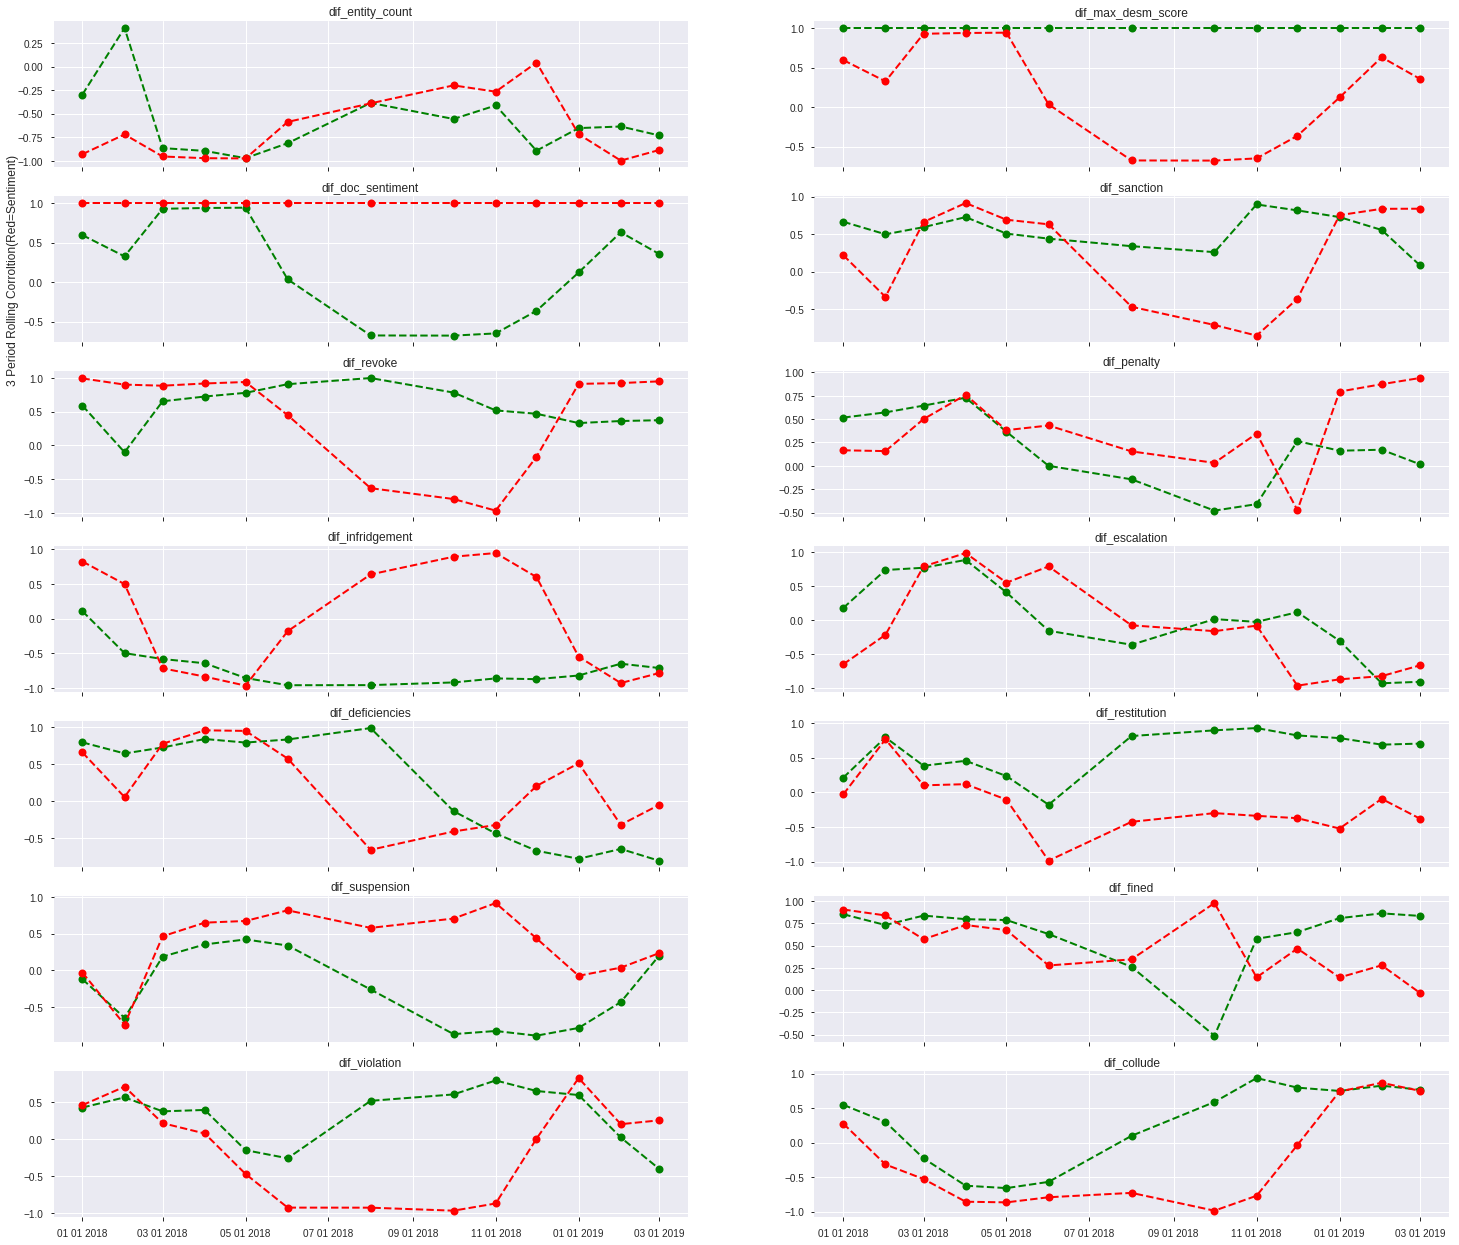

In [33]:
#total columns to plot 
totcols = len(desm_rolling_cor.columns)

#column names 
cols = df_corr.columns

#total number of rows to include in figure 
nrows = int(round(totcols/2,0))

#define figure and axies for each figure (nrows*ncols)
fig, axes = plt.subplots(nrows=nrows,ncols=2, sharey=False, sharex=True,squeeze=True,figsize=(25,22))


# Plot 3 period rolling corrolation of sentiment and similarity across each risk term used in search 
for i,ax in enumerate(axes.flat):
    
    #sentiment and desm score specific rows of the df_corr
    plot_desm = desm_rolling_cor.reset_index()
    plot_sent = sent_rolling_cor.reset_index()
    
    #Similarity Data
    x =  pd.DatetimeIndex(plot_desm['month_year'])
    y =  plot_desm[cols[i]]
    
    #Sentiment Data 
    X =  pd.DatetimeIndex(plot_sent['month_year'])
    Y =  plot_sent[cols[i]]
    
    #plot corrolation of sim and sent for each risk term across each period  
    ax.plot_date(x, y,'go--', linewidth=2, markersize=8)#, s=80)#, facecolors=colors, edgecolors='')
    ax.plot_date(X, Y,'go--', linewidth=2, markersize=8, color='red')#, s=80)#, facecolors=colors, edgecolors='')
    ax.set_title(cols[i], size=12)
    ax.xaxis.set_major_formatter(matplotlib.dates.DateFormatter('%m %d %Y'))
    if i ==2:
        ax.set_ylabel('3 Period Rolling Corroltion(Red=Sentiment)', size=12)
    
plt.show()

In [ ]:
#One hot encoding variables for time series 
idcol = ['entity']
datecol = ['month_year']
numcols = ['entity_count','max_desm_score','doc_sentiment','sanction','revoke','penalty', 'infridgement', 'escalation', 'deficiencies', 'restitution', 'suspension', 'fined', 'violation', 'collude']
catcols =['Sentiment_Bin', 'desm_term', 'scraper', 'source']

Time_Sub = TimeDF[idcol+datecol+numcols+catcols]
df_processed = pd.get_dummies(Time_Sub, prefix_sep="__",
                              columns=catcols)

In [ ]:
#SPLIT CATEGORICAL VARIBEL BASED ON RF MODEL 
Y = Time_Sub['source']
X = Time_Sub[numcols]
feature_names = list(X.columns.values)



# Split dataset into training set and test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,Y , test_size=0.3) # 70% training and 30% test

#Import Random Forest Model
from sklearn.ensemble import RandomForestClassifier

#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)

#get preds
y_pred=clf.predict(X_test)
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

import pandas as pd
feature_imp = pd.Series(clf.feature_importances_,index=feature_names).sort_values(ascending=False)
feature_imp

In [81]:
#vars to group the melted data on 
var_list=['entity','features']
metric=['value']

#group the df
dfs = []

group_df=melt_df[(melt_df['year']==2018) & (~melt_df['features'].isin(['entity_count',
                                                                          'sent_index',
                                                                          'sentence_sentiment',
                                                                          'max_desm_score',
                                                                          'doc_sentiment'
                                                                         ])
                                           )].groupby(var_list,as_index=False)[metric].mean()

catcols = numcols(df=group_df,numeric=False);print(catcols)
group_df[catcols] = group_df[catcols].apply(pd.Categorical)

In [8]:
import numpy as np
def convertlistsindf(df):
    for col in list(df):
        df[col].apply(lambda x: ' '.join(map(str, x)).strip() if isinstance(x,list) else x) 
    return df
               
def df_rowtypes(df,cols):
    df_copy = df.copy()
    df_copy.index = df.index
    df_copy.columns = df.columns

    #loop over indexes for each column and determine the type of data in each row of each column 
    #assignment to new dataframe based on idx location
    for col in cols:
        for i in df.index:
            val = type(df.loc[i, col]).__name__ 

            if val =='list':
                df_copy.loc[i, col] = len(df.loc[i, col])

            elif val =='dict':
                df_copy.loc[i, col] = len(df.loc[i, col].keys())

            else:
                df_copy.loc[i, col] = val

    return df_copy

def coldtypes(df):
    coltypes=[]
    for i in range(0,df.shape[1]):
        for j in range(0,df.shape[0]):
            if isinstance(df.iloc[j,i], list): 
                coltypes.append(type(df.iloc[j,i]))        
    return coltypes

def coldtype(df,col):a
    coltypes=[]
    for j in range(0,df.shape[0]):
        indx=df.columns.get_loc(col)
        if isinstance(df.iloc[j,indx], list): 
            coltypes.append(type(df.iloc[j,indx]))    
        else:
            coltypes.append(type(df.iloc[j,indx]))  
    return coltypes

### Identifying Stratified sample of negative postive and neutral sentences to visualize

In [ ]:

print(data_sent.shape,data_sentence.shape)

rows = []
_ = data_sent.apply(lambda row: [rows.append([row['jobname'],row['date'],row['entity'],row['source'],row['title'],row['summary']
                                              ,row['doc_sentiment'],sentence,sentiment])
                         for sentiment,sentence in zip(row.sentence_sentiment,row.sentence_tokenized_english)],axis=1)

SentDF = pd.DataFrame(rows,columns = data_sent.columns)
SentDF.sort_values(by='sentence_sentiment', inplace=True)
print(SentDF.shape)

#create sentiment bins
SentDF.loc[SentDF.sentence_sentiment <= -.05, 'Sentiment_Bin'] = 'Negative'
SentDF.loc[SentDF.sentence_sentiment > .05, 'Sentiment_Bin'] = 'Positive'
SentDF.loc[(SentDF.sentence_sentiment > -.06 )&(SentDF.sentence_sentiment < .06 ), 'Sentiment_Bin'] = 'Nuetral'

low_sents = SentDF[SentDF['sentence_sentiment'] < -.5].sort_values(by='doc_sentiment',ascending=True)
high_sents = SentDF[SentDF['sentence_sentiment'] > .5].sort_values(by='doc_sentiment',ascending=False)
mid_sents = SentDF[(SentDF['sentence_sentiment'] > -.05) &(SentDF['sentence_sentiment'] < .05) ].sort_values(by='doc_sentiment',ascending=False)
print(high_sents.shape,low_sents.shape,mid_sents.shape)

docs2include = list(low_sents['jobname'].unique())
docs2include.append(list(high_sents['jobname'].unique()))
docs2include.append(list(mid_sents['jobname'].unique()))
docs2include
#docs2include = high_sents['jobname'].head(5)
#docs2include = mid_sents['jobname'].head(5)


FinalDocs2Include = [
#negative
'UBS_03-14-19-11-32-43',
'Deutsche Bank_03-14-19-11-11-01',
'Wells Fargo_03-14-19-11-11-01',
#positive 
'UBS_03-14-19-11-32-43',
'Deutsche Bank_03-14-19-11-11-01',
'Wells Fargo_03-13-19-17-06-13',
#nuetral 
'Wells Fargo_03-13-19-17-06-13',
'Deutsche Bank_03-14-19-11-11-01',
'UBS_03-14-19-11-32-43',]

FinalSentDF = SentDF[SentDF['jobname'].isin(FinalDocs2Include)]
FinalSentDF.to_pickle("//home//nlpsomnath//NegNews//zackc//ContainerOutput//Sentiment_Sentence_DF.pickle")
#data = pd.read_pickle("C:/Users/caridza/Desktop/pythonScripts/NLP/Zacks_NLP_Stuff/Data/All_Source_Data.pickle")
FinalSentDF.to_csv("//home//nlpsomnath//NegNews//zackc//ContainerOutput//Sentiment_Sentence_DF.csv",index=False)

### Summarization of Sentiment

In [6]:
df_sub = data[['entity','date','jobname','source','title','summary','entity_count','max_desm_score','doc_sentiment']]
pandas_profiling.ProfileReport(df_sub)
numcols = list(df_sub.select_dtypes(include=[np.number]).columns.values)
catcols = catcols = df_sub.columns.difference(list(df_sub.select_dtypes(include=[np.number]).columns.values))
datecol = pd.to_datetime(df_sub['date'],errors='coerce')
#create datetime index for plotting
df_sub.index = datecol
df_plot = df_sub.loc['2016-1-1':'2019-6-10']
df_plot['year'], df_plot['month'] = df_plot['date'].dt.year, df_plot['date'].dt.month

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [17]:
#Avg sentiment by Entity over time 
#resample data at 6m intervals to smooth view 
df_plot['date2']=df_plot.date.dt.to_period('M')
df_group=df_plot[['date2','entity','doc_sentiment','max_desm_score']].groupby(['entity','date2']).mean().reset_index()



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
df_plot['entity'].value_counts()
Entities=['Deutsche Bank','Wells Fargo','Axos','Chase Bank','Barclays','CFD','Wedbush','Cetera','UBS' ,'LPL', 'Lek','MUFG']


/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.5/dist-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40]), <a list of 41 Text xticklabel objects>)

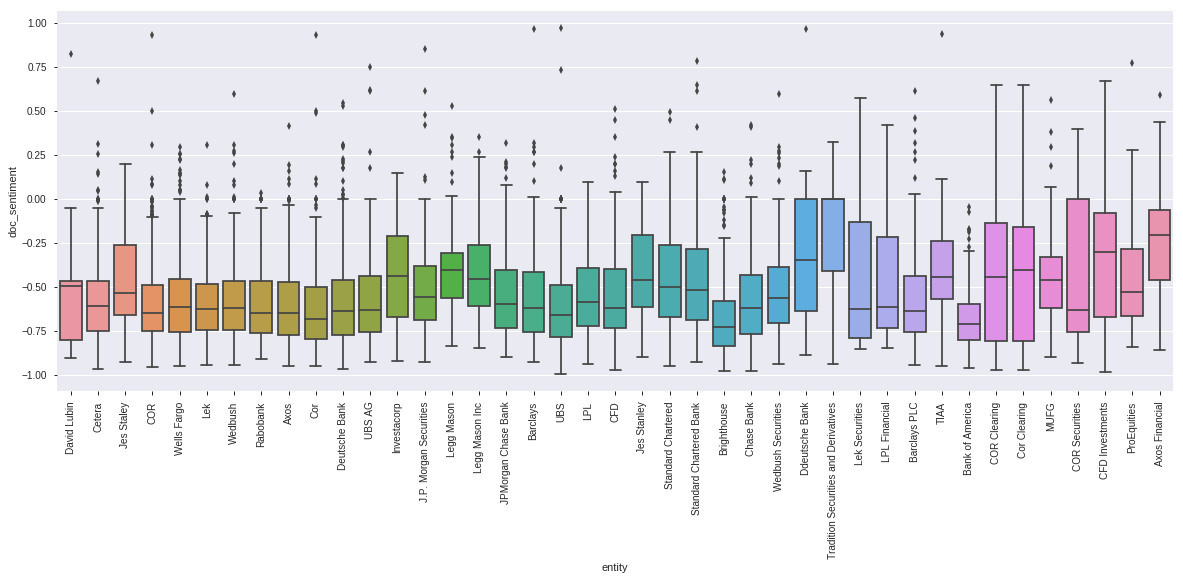

In [19]:
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline

df_plot.loc[df_plot.doc_sentiment <= -.05, 'Sentiment_Bin'] = 'Negative'
df_plot.loc[df_plot.doc_sentiment > .05, 'Sentiment_Bin'] = 'Positive'
df_plot.loc[(df_plot.doc_sentiment > -.06 )&(df_plot.doc_sentiment < .06 ), 'Sentiment_Bin'] = 'Nuetral'

fig, ax = plt.subplots(figsize=(20,7))
#barchart 
sns.boxplot(x="entity", y="doc_sentiment", data=df_plot, ax=ax)
plt.xticks(rotation=90)
#sns.boxplot(x="year", y="doc_sentiment", data=df_plot[df_plot['entity']=='Wells Fargo'], ax=ax)
#plt.title('Wells Fargo Sentiment by Year')
#g.set_xticklabels(rotation=90)
# Grouped boxplot
#sns.boxplot(x="entity", y="max_desm_score", hue="Sentiment_Bin", data=df_plot, palette="Set1")



In [109]:
list(df_plot)

['entity',
 'date',
 'jobname',
 'source',
 'title',
 'summary',
 'entity_count',
 'max_desm_score',
 'doc_sentiment',
 'year',
 'month',
 'date2']

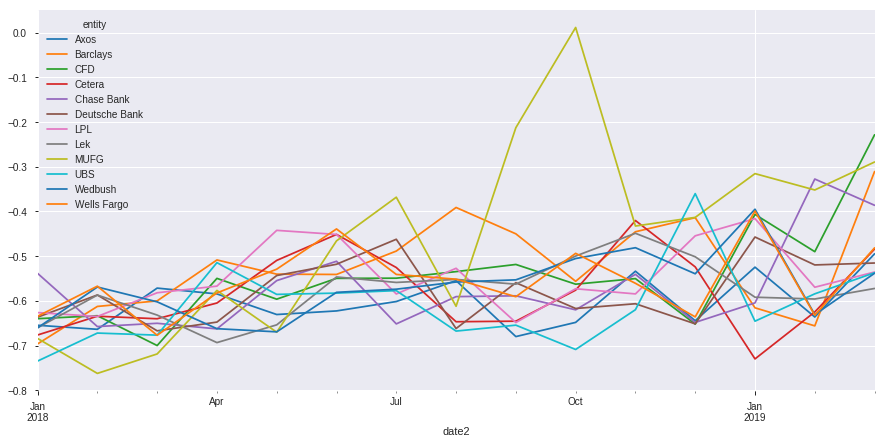

In [105]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,7))
df_plot[df_plot['entity'].isin(Entities)].groupby(['date2','entity']).mean()['doc_sentiment'].unstack().plot(ax=ax)#plot(kind='kde', ax=ax)

/usr/local/lib/python3.5/dist-packages/matplotlib/pyplot.py:935: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  return gcf().gca(**kwargs)


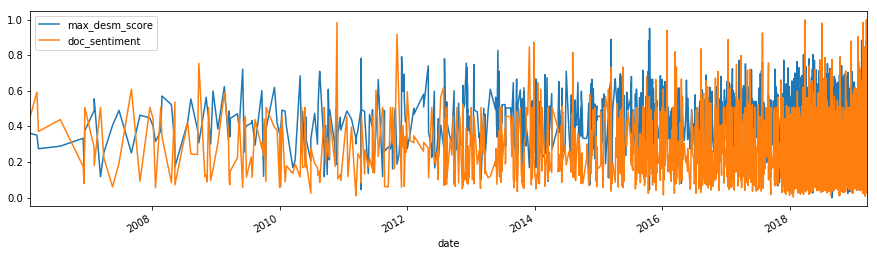

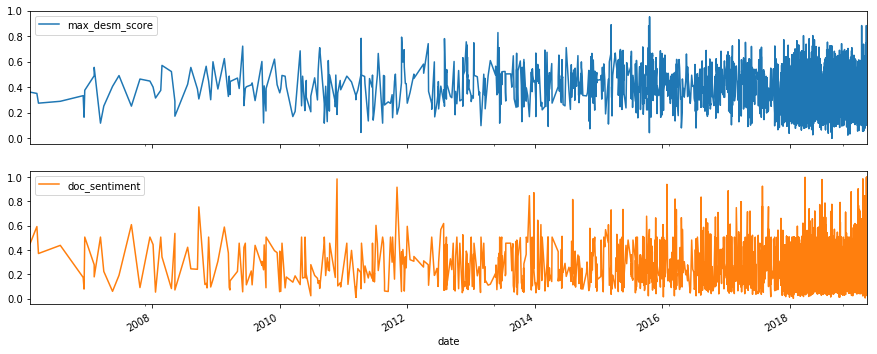

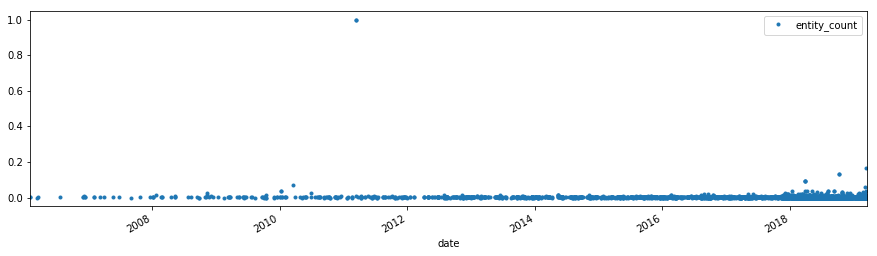

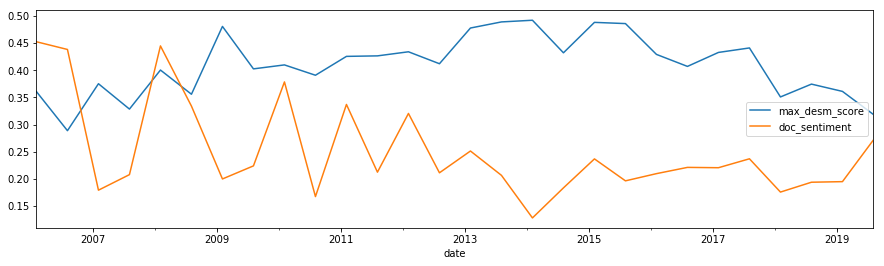

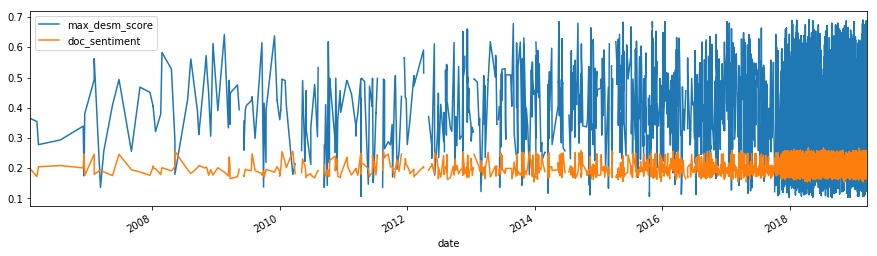

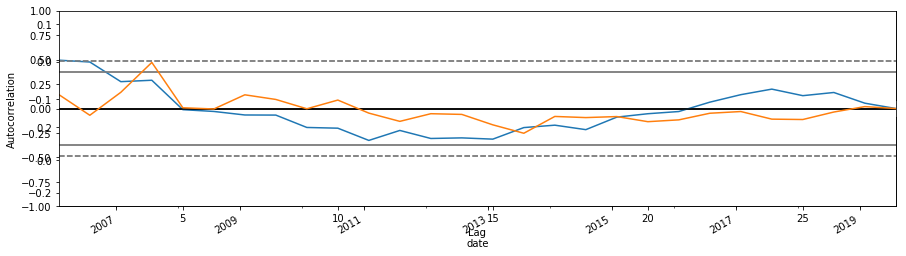

In [5]:
%matplotlib inline
df_plot[['max_desm_score','doc_sentiment']].plot(figsize=(15,4))
df_plot[['max_desm_score','doc_sentiment']].plot(subplots=True, figsize=(15,6))
df_plot.plot(y=["entity_count"], figsize=(15,4), style='.')

#resample data at 6m intervals to smooth view 
df_plot[["max_desm_score", "doc_sentiment"]].resample("6m").median().plot(figsize=(15,4))

#plot rolling window
df_plot[["max_desm_score", "doc_sentiment"]].rolling(182).median().plot(figsize=(15,4))

#differencing 
df_plot[["max_desm_score", "doc_sentiment"]].resample("6m").median().diff().plot(subplots=True, figsize=(15,4))

#plot / identify periodcity and corrolation 
#his produces an autocorrelation plot: the correlation of a time series with itself at a range of lag times. We have applied 
#it to the downsampled yearly time series which makes the calculation a lot quicker. Since the cadence of the time series is 
#one year, the “Lag” axis is measured in years. The first peak (after a lag of 0) is around 11 years, meaning that the series correlates well with itself at a lag time of 11 years. This is the well-known solar activity cycle.
pd.plotting.autocorrelation_plot(df_plot["max_desm_score"].resample("6m").median())
pd.plotting.autocorrelation_plot(df_plot["doc_sentiment"].resample("6m").median())


In [19]:
data[data['source']=='sbs']['source'].value_counts()

Series([], Name: source, dtype: int64)

In [ ]:
#descriptive stats on cat and num cols 
#plot distributions of data 
#plot time series of data 
#lda plot of summaries or kmeans (interactive plotty)
#corrolation between similarity and sentiment over time 


In [34]:
#list all collections in each database (2 ways)
#client = MongoClient("172.24.0.4:27017")
#client = MongoClient("192.168.64.2:27017")
client = MongoClient("172.27.0.3:27017")


db_collections = dict((db, [collection for collection in client[db].collection_names()])
                      for db in client.database_names())
print(db_collections)

#get data into dataframe 
coll = client['negative_news']['processed_results']
data = list(coll.find({}))
data = pd.DataFrame(data)
print(data.shape)
data['entity'].unique()
data.columns

{'config': ['system.sessions'], 'local': ['startup_log'], 'negative_news': ['rss_feed', 'broker_check_owners', 'broker_check_meta', 'broker_check_disclosures', 'scrape_feed', 'processed_results'], 'admin': ['system.version']}
(6394, 25)


Index(['_id', 'all_search_terms', 'classification_tuple_lists', 'content', 'date', 'desm_sentences', 'desm_term', 'doc_sentiment', 'employment_fuzzy_score_final', 'entity', 'entity_count', 'fine_amt_norm', 'fine_report_strings', 'jobname', 'location_fuzzy_score_final', 'max_classification_score', 'max_desm_score', 'name_fuzzy_score_final', 'regulatory_flag', 'scraper', 'source', 'summary', 'title', 'total_entity_fine_amt', 'url'], dtype='object')

In [35]:
data.head()

_id                                   all_search_terms                         classification_tuple_lists                                            content                date                                     desm_sentences desm_term  doc_sentiment  employment_fuzzy_score_final       entity  entity_count  fine_amt_norm                                fine_report_strings                        jobname  location_fuzzy_score_final  max_classification_score  max_desm_score  name_fuzzy_score_final  regulatory_flag        scraper             source                                            summary                                              title  total_entity_fine_amt                                                url
0  5c8938fbb1a779022d863f0e  [, Fined, Violation, Penalty, Fraud, Fine, San...  [[2, regulatory_reference], [7, mgmt_change], ...  Wells Fargo will pay $575 million in a settlem... 2018-12-28 00:00:00  [Wells Fargo will pay $575 million in a settle...     fraud      -0.206500                           0.0  Wells Fargo             8       0.020139  [Fine in the amount of $575,000,000 found for ...  Wells Fargo_03-13-19-17-06-13                         0.0                       NaN        0.444053               68.333333            False        NewsAPI           CBS News  The settlement resolves investigations by all ...  Wells Fargo to pay $575 million in settlement ...            575000000.0  https://www.cbsnews.com/news/wells-fargo-settl...
1  5c8938fbb1a779022d863f0f  [, Fined, Violation, Penalty, Fraud, Fine, San...  [[2, regulatory_reference], [7, monetary_fine_...  Wells Fargo & Co. has agreed to pay $575 milli... 2018-12-28 00:00:00  [Wells Fargo & Co. has agreed to pay $575 mill...     fraud      -0.668567                           0.0  Wells Fargo            10       0.020139  [Fine in the amount of $575,000,000 found for ...  Wells Fargo_03-13-19-17-06-13                         0.0                       NaN        0.439644               60.840000            False  BingSearchAPI    Marketwatch.com  Wells Fargo fined $575 million by all 50 state...    Wells Fargo fined $575 million by all 50 states            575000000.0  https://www.marketwatch.com/story/wells-fargo-...
2  5c8938fbb1a779022d863f10  [, Fined, Violation, Penalty, Fraud, Fine, San...  [[3, monetary_fine_minor], [2, regulatory_refe...  Wells Fargo  — the third-largest US bank with ... 2018-12-30 13:40:29  [Wells Fargo  — the third-largest US bank with...     fraud      -0.665833                           0.0  Wells Fargo            18       0.020139  [Fine in the amount of $575,000,000 found for ...  Wells Fargo_03-13-19-17-06-13                         0.0                       NaN        0.437916               83.695652            False  BingSearchAPI  Finance.yahoo.com  California attorney general Xavier Becerra tor...  Wells Fargo Says Bitcoin Too Risky for Clients...            575000000.0  https://finance.yahoo.com/news/wells-fargo-say...
3  5c8938fbb1a779022d863f11  [, Fined, Violation, Penalty, Fraud, Fine, San...                                       [[0, other]]  In his recent interview with CNBC, America’s m... 2019-03-10 00:00:00  [Barry Silbert, Founder, and CEO of Digital Cu...     fraud      -0.441067                           0.0  Wells Fargo             3       0.000000                                                 []  Wells Fargo_03-13-19-17-06-13                         0.0                       NaN        0.424011               41.142857            False  BingSearchAPI        Newsbtc.com  “Wells Fargo, a Buffett investment, has been f...  Wells Fargo, Warren Buffett Investment, Paid 2...                    0.0  https://www.newsbtc.com/2019/03/10/wells-fargo...
4  5c8938fbb1a779022d863f12  [, Fined, Violation, Penalty, Fraud, Fine, San...                         [[7, monetary_fine_major]]  Wells Fargo has agreed to pay California $5 mi... 2019-01-03 00:00:00  [Wells Fargo has agreed to pay California $5 m...     fraud   